# load imports

In [16]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
directory='PlantVillage',
seed=123,
shuffle = True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Single Image :  tf.Tensor(
[[[141.98236  115.98237  116.98237 ]
  [136.82382  110.823814 111.823814]
  [107.35246   81.35246   82.35246 ]
  ...
  [173.01381  155.01381  151.01381 ]
  [181.93741  163.93741  159.93741 ]
  [195.95111  177.95111  173.95111 ]]

 [[137.87445  111.87446  112.87446 ]
  [136.8248   110.82481  111.82481 ]
  [132.12982  106.129814 107.129814]
  ...
  [175.0646   157.0646   153.0646  ]
  [176.98244  158.98244  154.98244 ]
  [184.96088  166.96088  162.96088 ]]

 [[117.12743   91.12743   92.12743 ]
  [112.31633   86.31633   87.31633 ]
  [144.35968  118.35967  119.35967 ]
  ...
  [176.0387   158.0387   154.0387  ]
  [176.02917  158.02917  154.02917 ]
  [181.049    163.049    159.049   ]]

 ...

 [[107.330246  81.330246  80.330246]
  [145.66852  119.6685   118.6685  ]
  [126.09693  100.09693   99.09693 ]
  ...
  [162.9805   142.9805   141.9805  ]
  [166.96677  146.96677  145.96677 ]
  [170.96283  150.96283  149.96283 ]]

 [[114.9

In [20]:
len(class_names)

3

In [1]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

NameError: name 'plt' is not defined

In [22]:
len(dataset)

68

In [23]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [24]:
train_ds = dataset.take(54)
len(train_ds)

54

In [25]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [26]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [27]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [28]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [29]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
len(train_ds)

54

In [31]:
len(val_ds)

6

In [32]:
len(test_ds)

8

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [36]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 255, 255, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 253, 253, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 126, 126, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 124, 124, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 142s 3s/step - loss: 0.9569 - accuracy: 0.4878 - val_loss: 0.8945 - val_accuracy: 0.4844
Epoch 2/20
54/54 [==============================] - 130s 2s/step - loss: 0.8399 - accuracy: 0.5666 - val_loss: 0.6663 - val_accuracy: 0.7292
Epoch 3/20
54/54 [==============================] - 121s 2s/step - loss: 0.5620 - accuracy: 0.7743 - val_loss: 0.5178 - val_accuracy: 0.7500
Epoch 4/20
54/54 [==============================] - 123s 2s/step - loss: 0.4531 - accuracy: 0.8177 - val_loss: 0.4146 - val_accuracy: 0.8177
Epoch 5/20
54/54 [==============================] - 410s 8s/step - loss: 0.3313 - accuracy: 0.8744 - val_loss: 0.2968 - val_accuracy: 0.8906
Epoch 6/20
54/54 [==============================] - 147s 3s/step - loss: 0.2632 - accuracy: 0.8958 - val_loss: 0.3212 - val_accuracy: 0.8906
Epoch 7/20
54/54 [==============================] - 134s 2s/step - loss: 0.2660 - accuracy: 0.8976 - val_loss: 0.2171 - val_accuracy: 0.9062
Epoch 8/20
54

In [45]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 671ms/step - loss: 0.0314 - accuracy: 0.9922


In [44]:
model.save("model.h5")

In [47]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 20, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9569183588027954,
 0.8398853540420532,
 0.5620450973510742,
 0.45307305455207825,
 0.3313418924808502]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

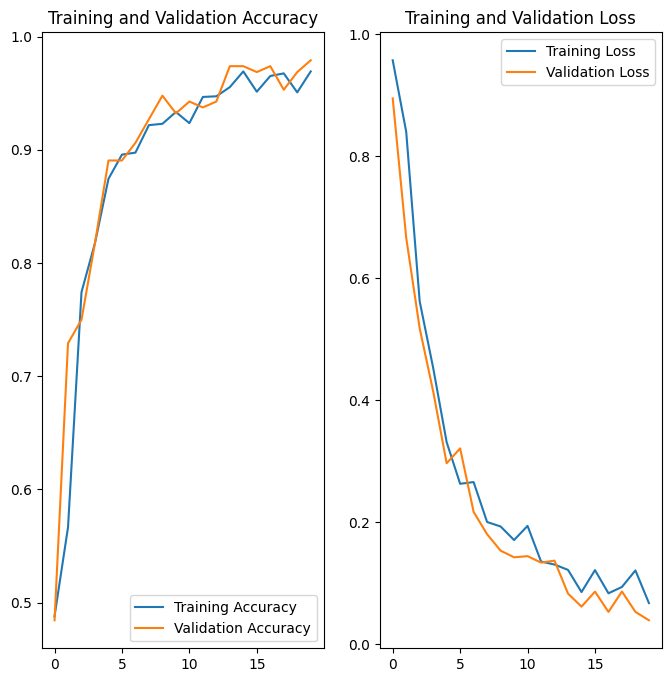

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
model = tf.keras.models.load_model('model.h5')

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


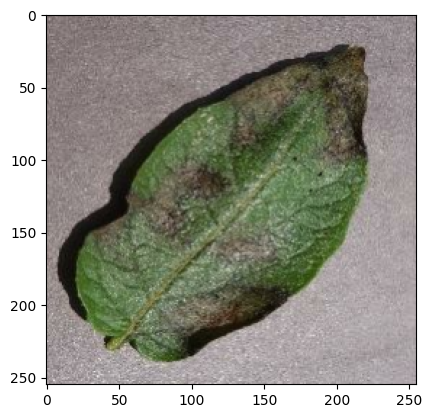

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

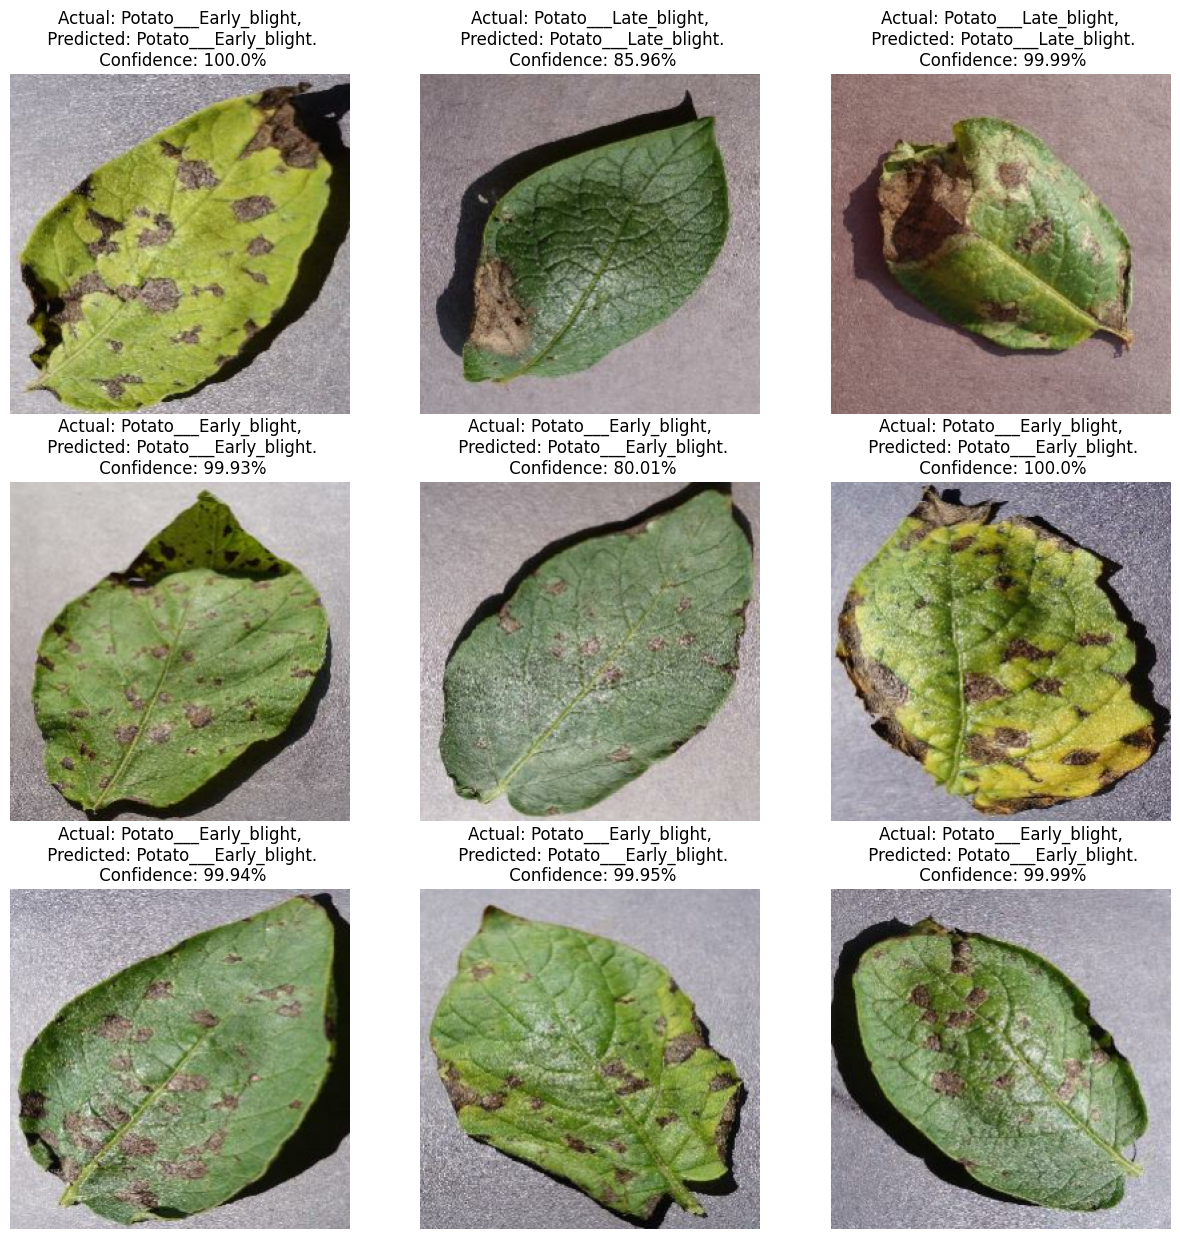

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [54]:
import tensorflow as tf
print(tf.__version__)


2.5.0


## 